In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})
import matplotlib.pyplot as plt
import matplotlib.font_manager
import warnings
warnings.filterwarnings('ignore')

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

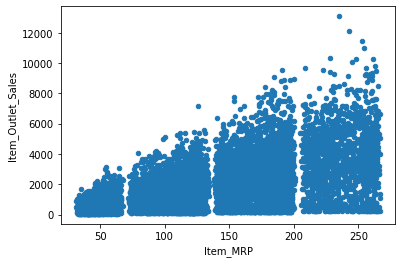

In [2]:
df = pd.read_csv("Big-Mart-Sales-master/Train.csv")
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

In [3]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP','Item_Outlet_Sales']])
df[['Item_MRP','Item_Outlet_Sales']].head()

,Item_MRP,Item_Outlet_Sales
0,0.927507,0.283587
1,0.072068,0.031419
2,0.468288,0.158115
3,0.640093,0.053555
4,0.095805,0.073651


In [4]:
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

In [5]:
random_state = np.random.RandomState(1024)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

OUTLIERS :  447 INLIERS :  8076 Angle-based Outlier Detector (ABOD)


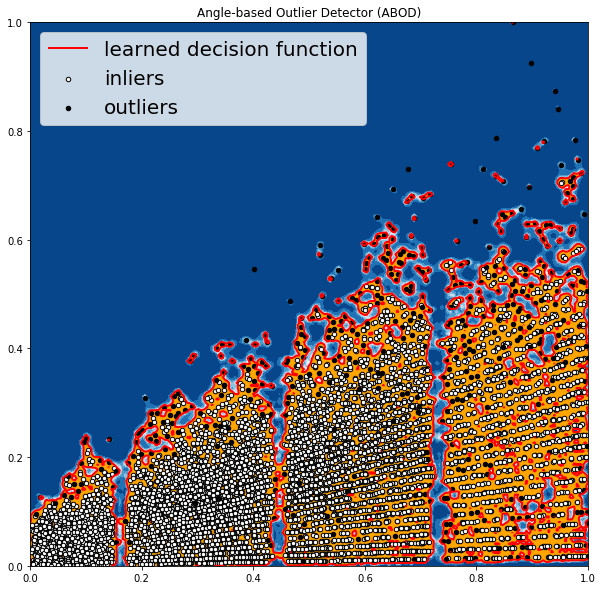

OUTLIERS :  427 INLIERS :  8096 Cluster-based Local Outlier Factor (CBLOF)


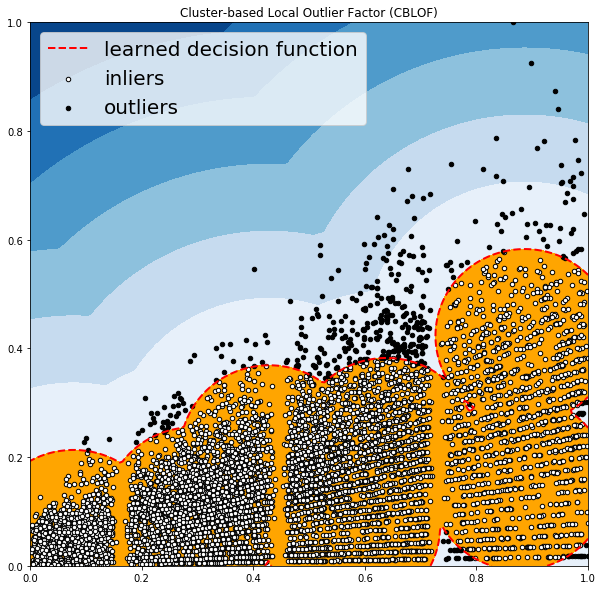

OUTLIERS :  364 INLIERS :  8159 Feature Bagging


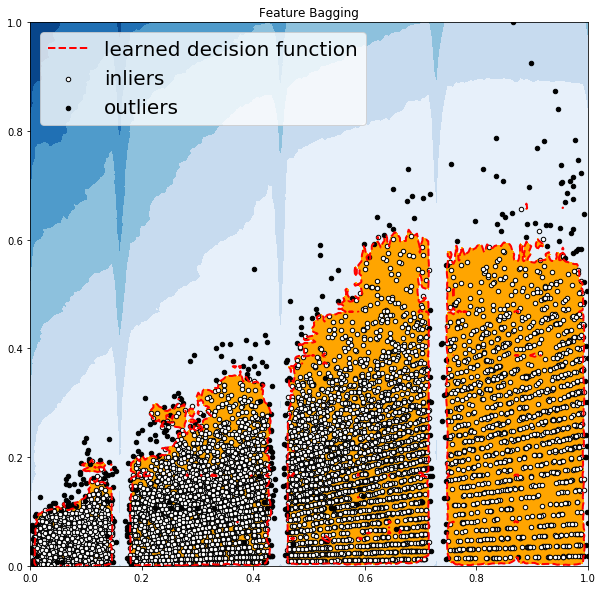

OUTLIERS :  501 INLIERS :  8022 Histogram-base Outlier Detection (HBOS)


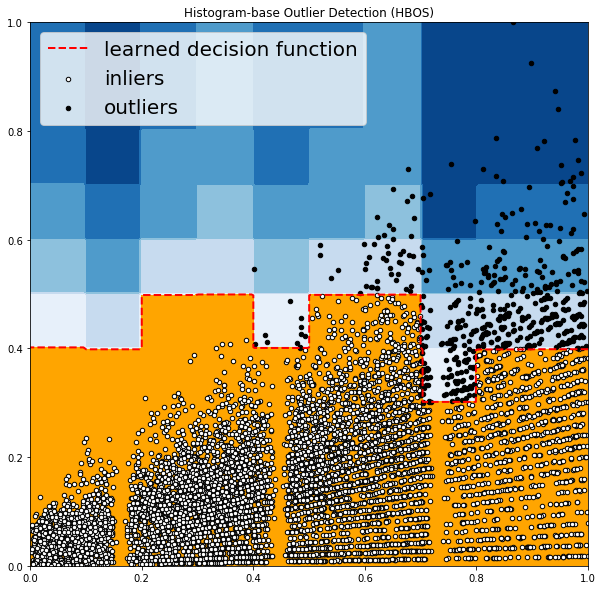

OUTLIERS :  427 INLIERS :  8096 Isolation Forest


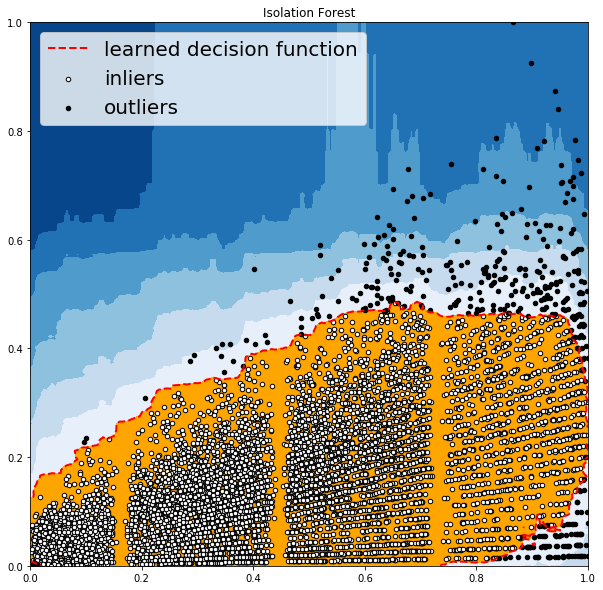

OUTLIERS :  311 INLIERS :  8212 K Nearest Neighbors (KNN)


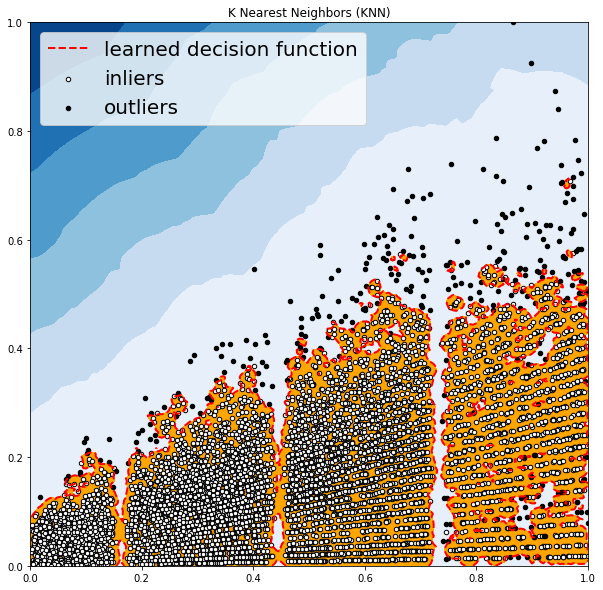

OUTLIERS :  176 INLIERS :  8347 Average KNN


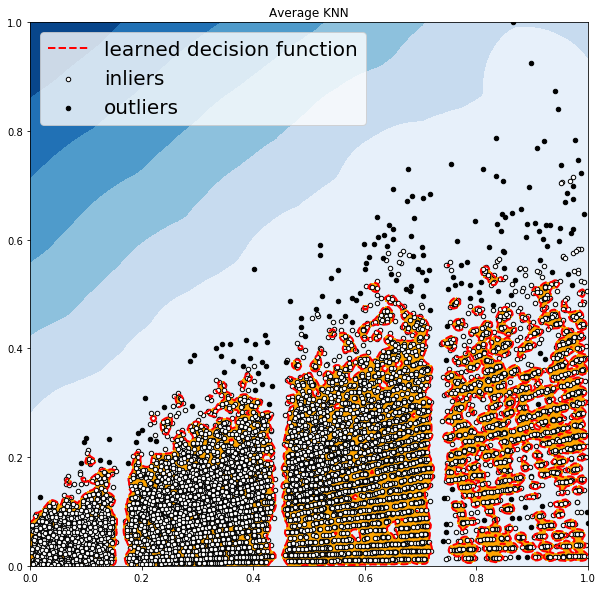

In [6]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
 
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['Item_MRP'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['Item_Outlet_Sales'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['Item_MRP'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['Item_Outlet_Sales'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

In [11]:
clf.decision_function(X)

array([0.0044358 , 0.00195095, 0.00364106, ..., 0.00209729, 0.00188418,
       0.00305425])

In [18]:
pd.concat([df,pd.DataFrame(y_pred)],axis=1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,outlier,0
0,FDA15,9.300,Low Fat,0.016047,Dairy,0.927507,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.283587,0,0
1,DRC01,5.920,Regular,0.019278,Soft Drinks,0.072068,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.031419,0,0
2,FDN15,17.500,Low Fat,0.016760,Meat,0.468288,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.158115,0,0
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,0.640093,OUT010,1998,NaN,Tier 3,Grocery Store,0.053555,0,0
4,NCD19,8.930,Low Fat,0.000000,Household,0.095805,OUT013,1987,High,Tier 3,Supermarket Type1,0.073651,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,0.777729,OUT013,1987,High,Tier 3,Supermarket Type1,0.210293,0,0
8519,FDS36,8.380,Regular,0.046982,Baking Goods,0.326263,OUT045,2002,NaN,Tier 2,Supermarket Type1,0.039529,0,0
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,0.228492,OUT035,2004,Small,Tier 2,Supermarket Type1,0.088850,0,0
8521,FDN46,7.210,Regular,0.145221,Snack Foods,0.304939,OUT018,2009,Medium,Tier 3,Supermarket Type2,0.138835,0,0


In [10]:
dfx.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'outlier'],
      dtype='object')

In [ ]:
for ax, catplot in zip(axes, df.dtypes[object_bol].index):
    sns.countplot(y=catplot, data=df, ax=ax, order=np.unique(df.values))

plt.tight_layout()  
plt.show()

In [12]:
dfx.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
outlier                         2
dtype: int64

Item_Fat_Content
normal


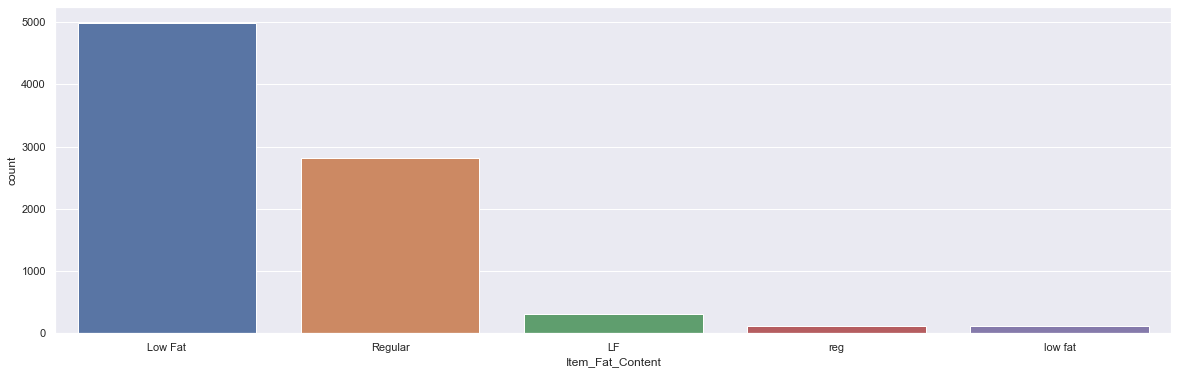

outlier


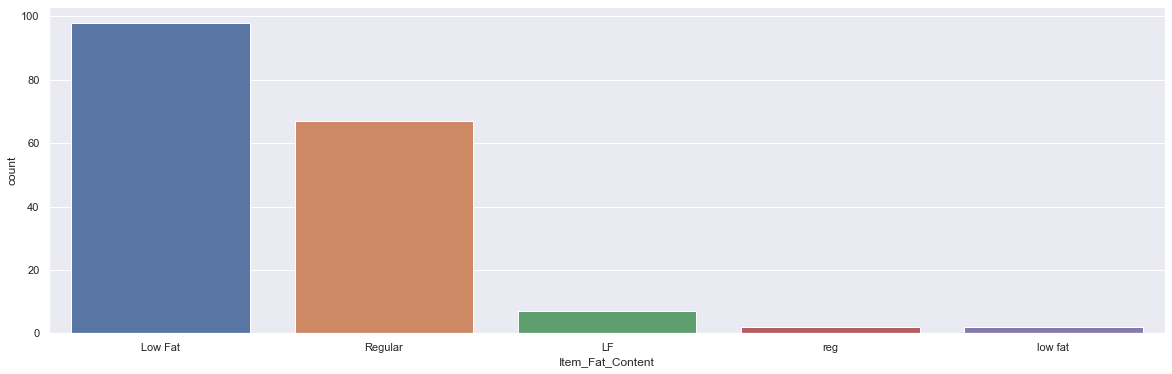

Item_Type
normal


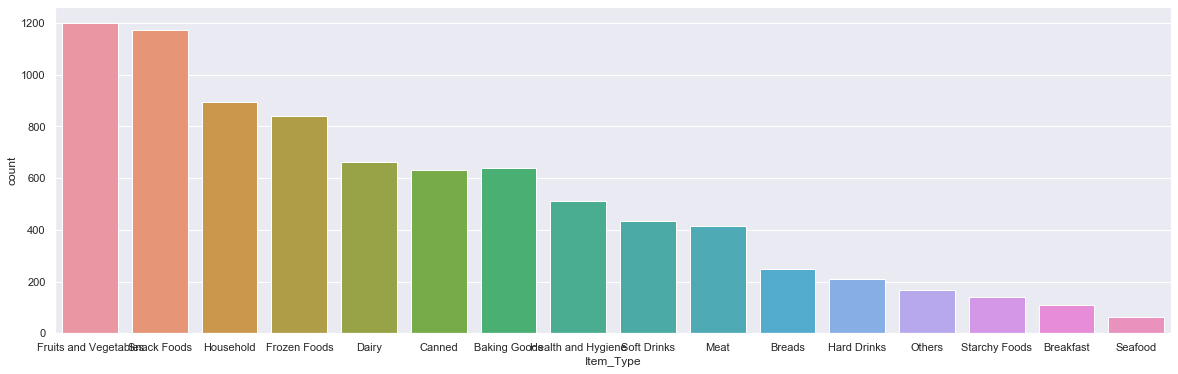

outlier


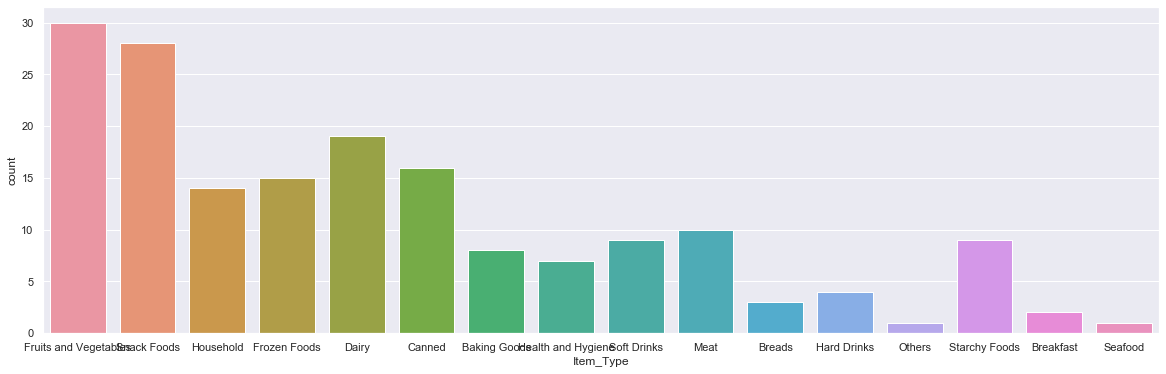

Outlet_Identifier
normal


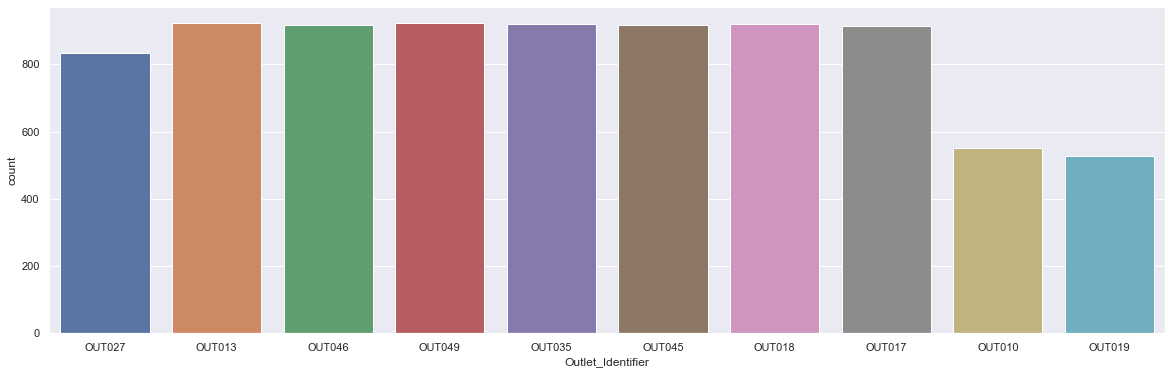

outlier


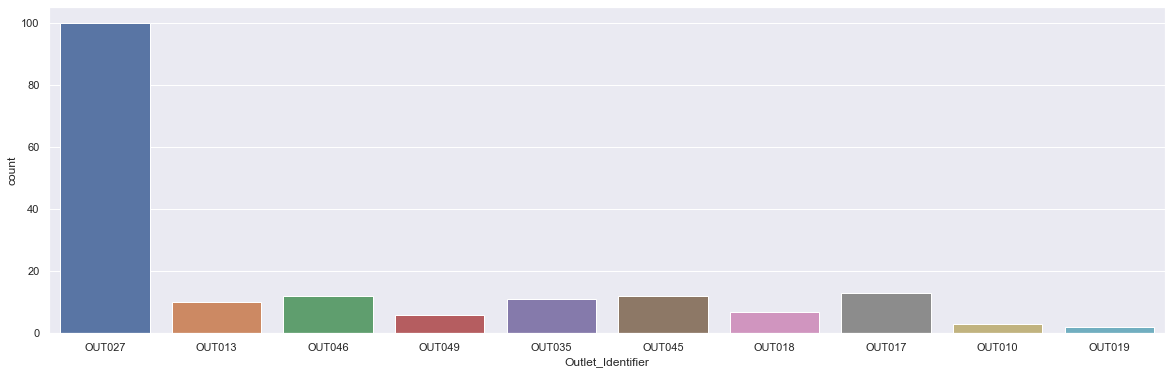

Outlet_Establishment_Year
normal


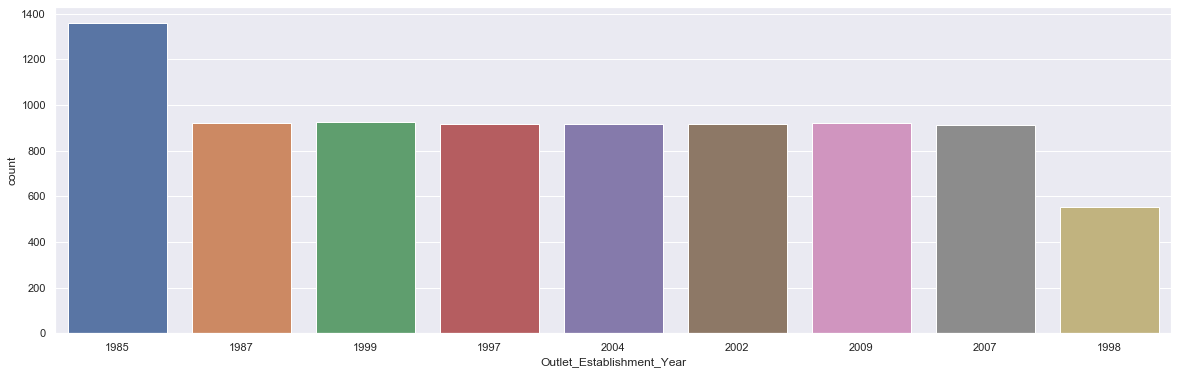

outlier


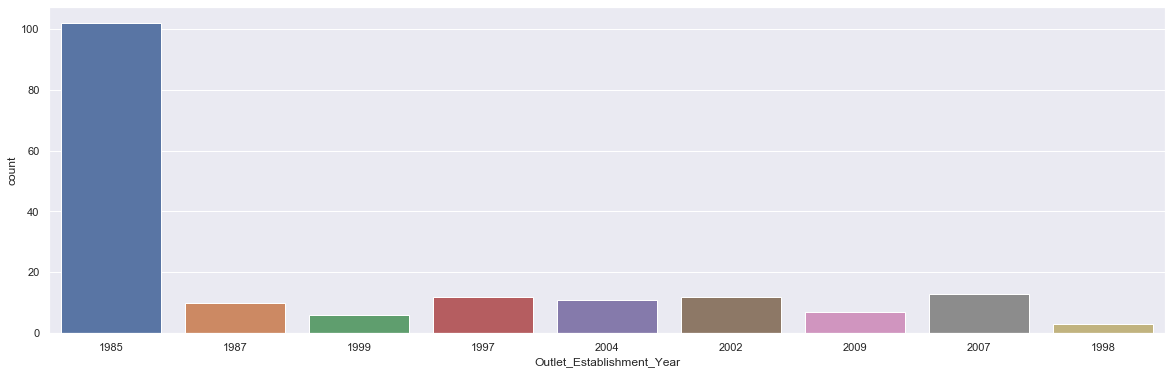

Outlet_Size
normal


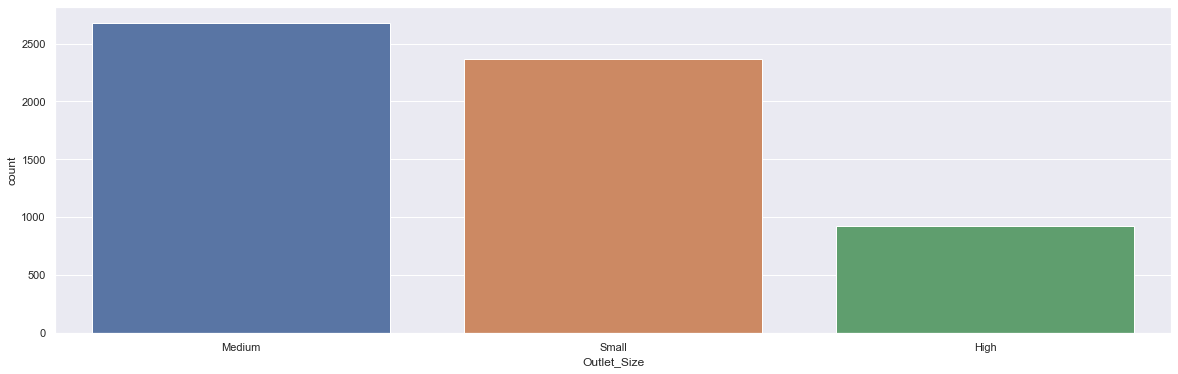

outlier


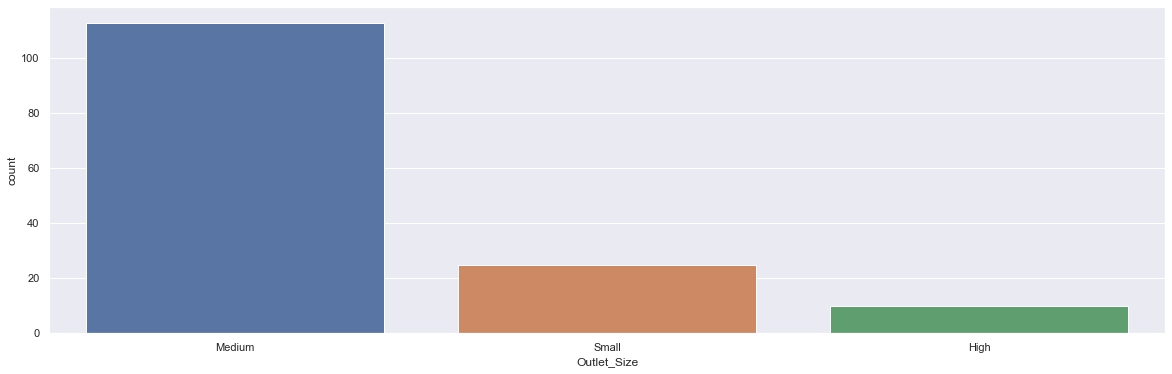

Outlet_Location_Type
normal


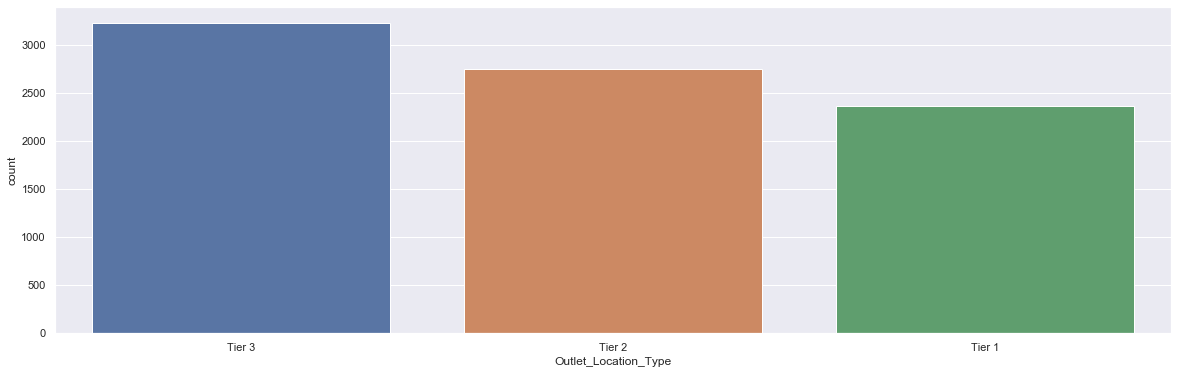

outlier


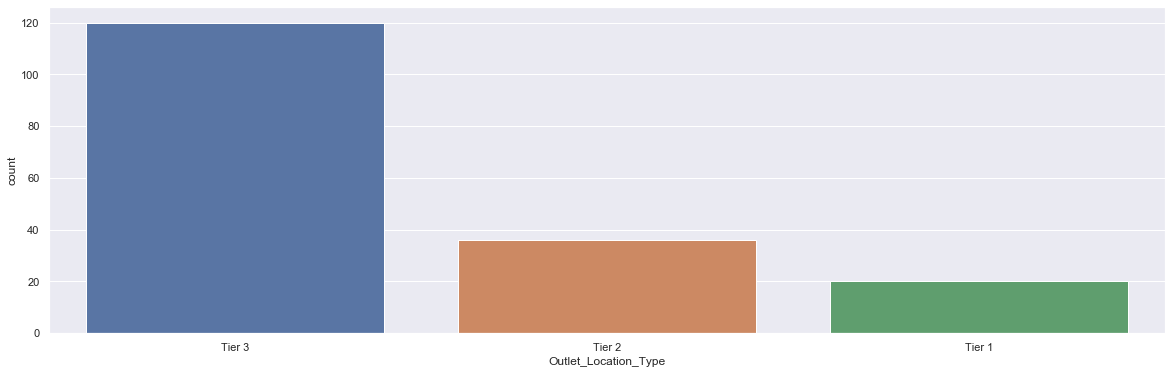

Outlet_Type
normal


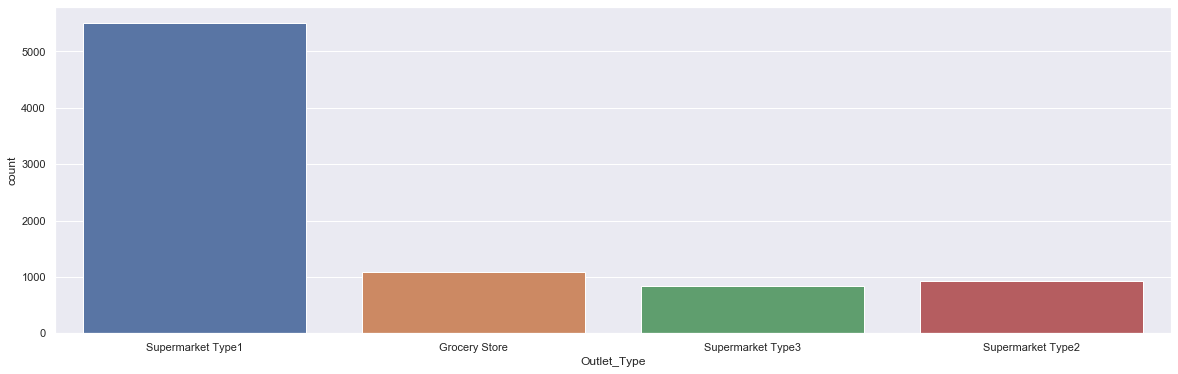

outlier


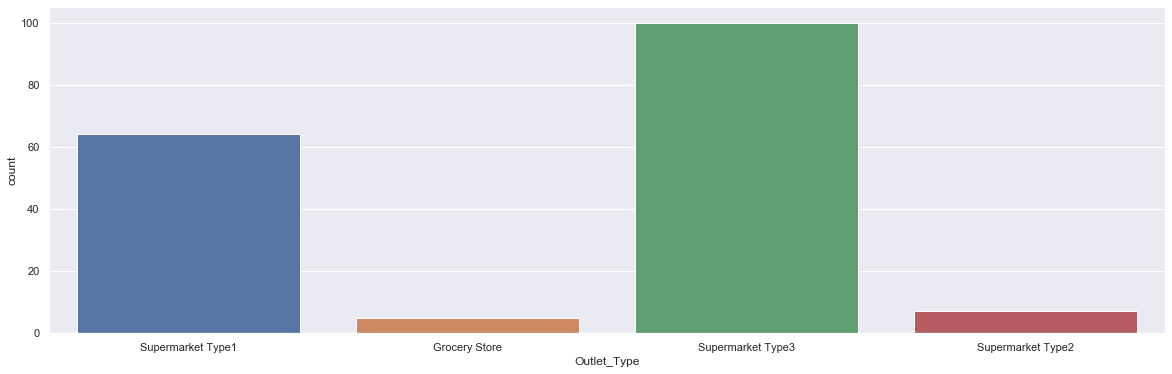

outlier
normal


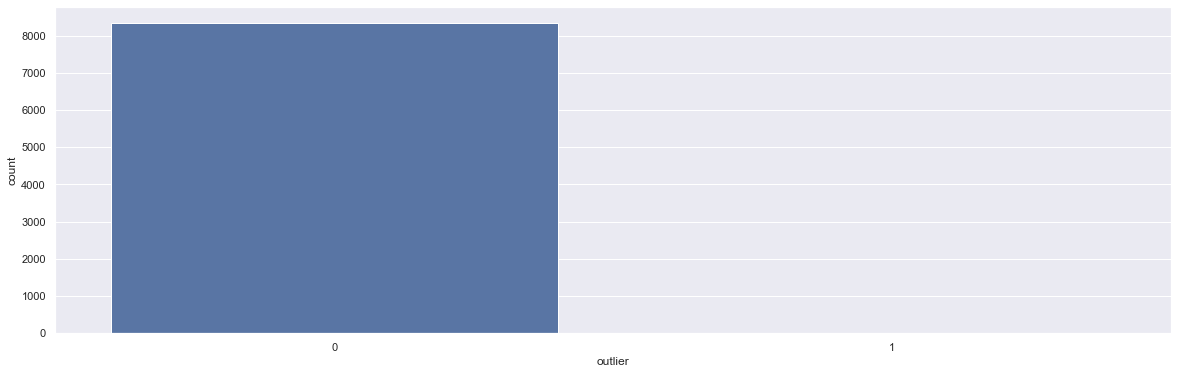

outlier


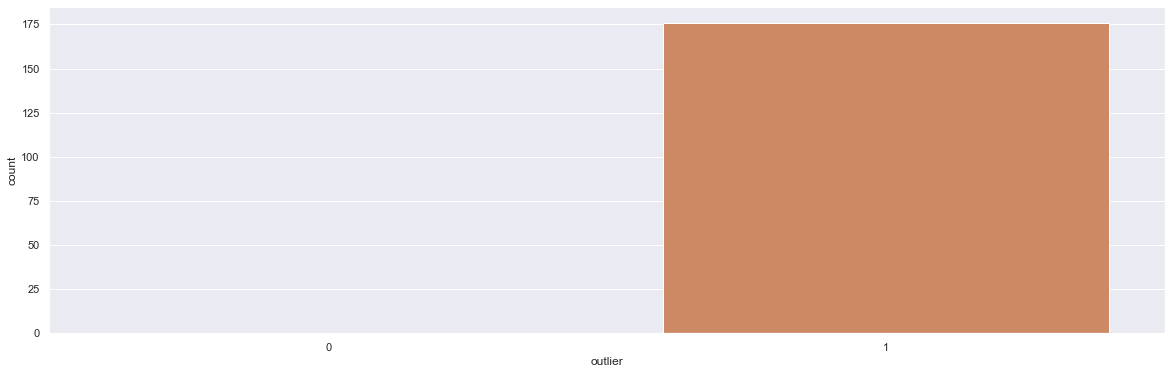

In [33]:
#categories plot
sns.set(rc={'figure.figsize':(20,6)})
for i in dfx.columns:
    if dfx[i].dtype == np.float64:
        continue
    if dfx[i].nunique()>20:
        continue
    print(i)
    print('normal')    
    sns.countplot(x=i, data=dfx[dfx['outlier']==0],order =dfx[i].value_counts().index)
    plt.show()
    print('outlier')
    sns.countplot(x=i, data=dfx[dfx['outlier']==1],order =dfx[i].value_counts().index)
    plt.show()

Item_Weight
normal


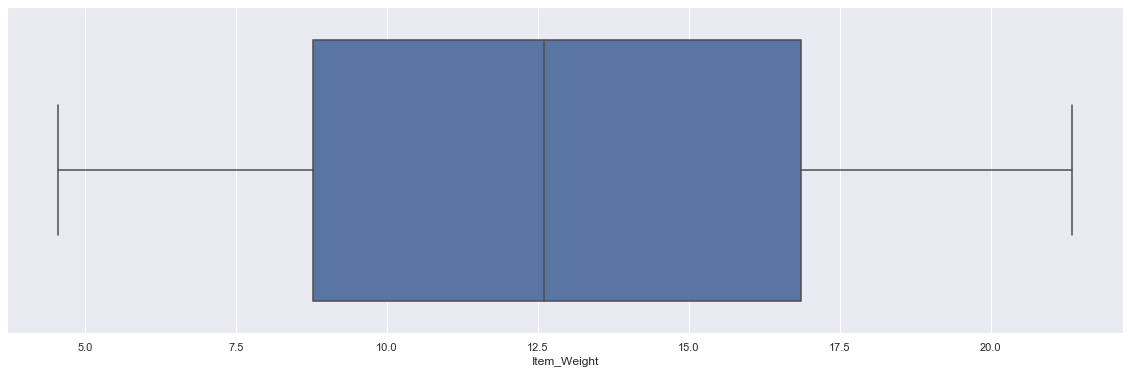

outlier


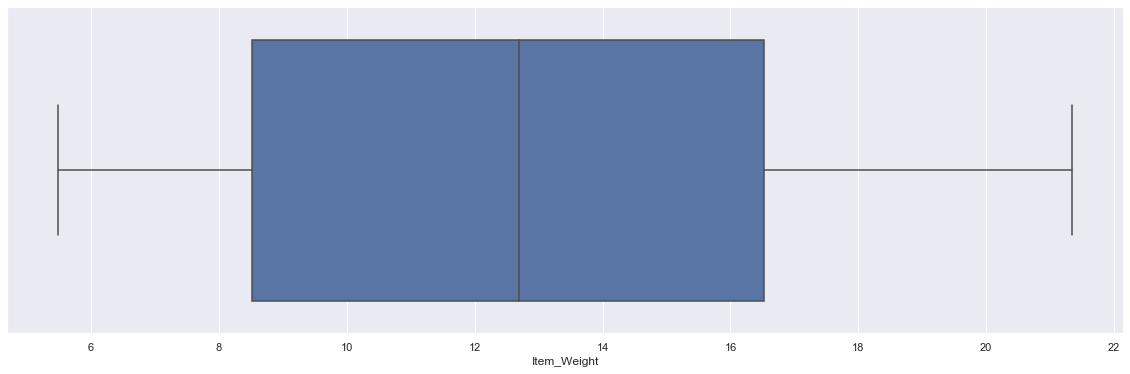

Item_Visibility
normal


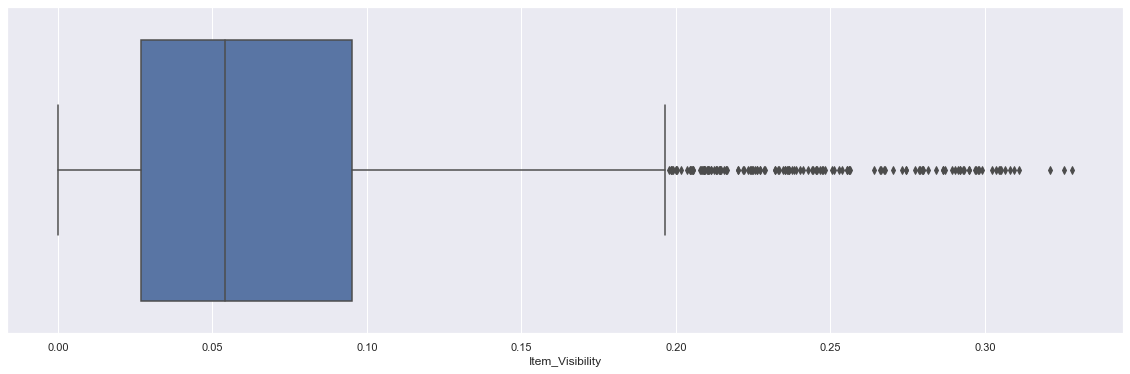

outlier


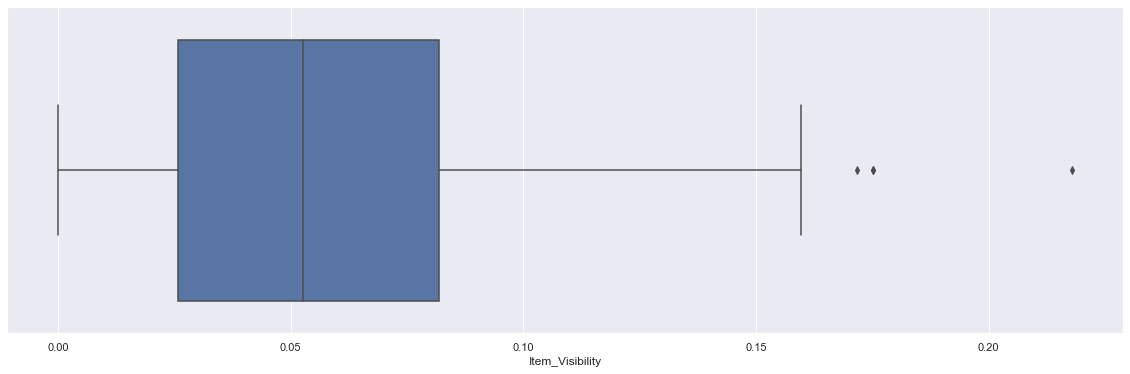

Item_MRP
normal


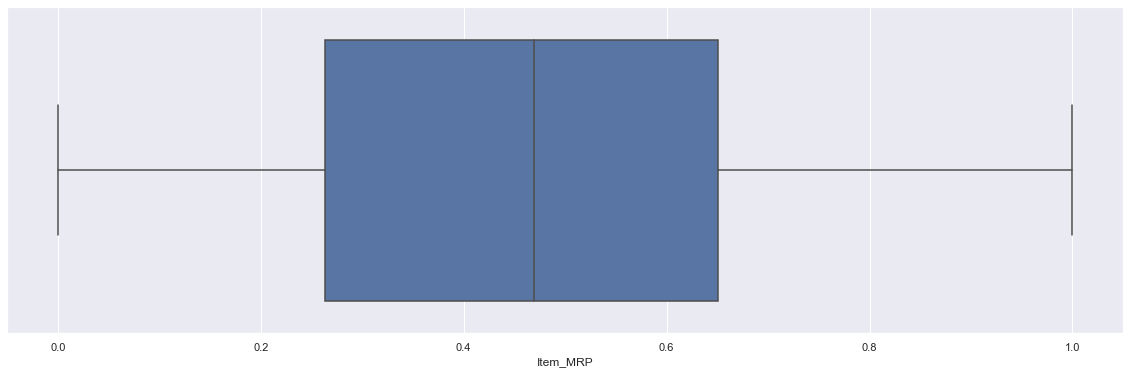

outlier


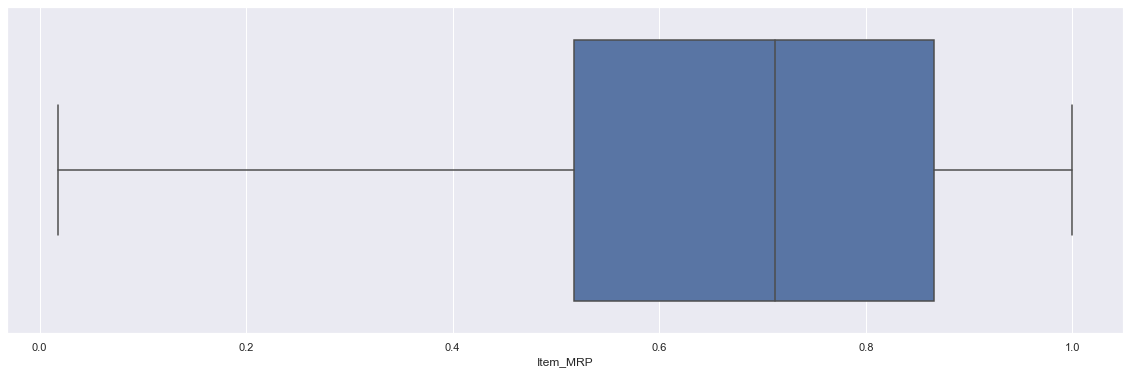

Item_Outlet_Sales
normal


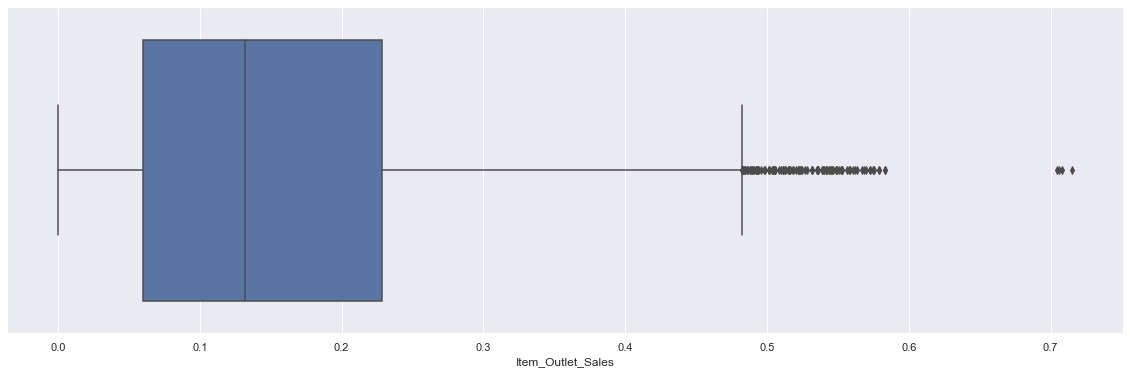

outlier


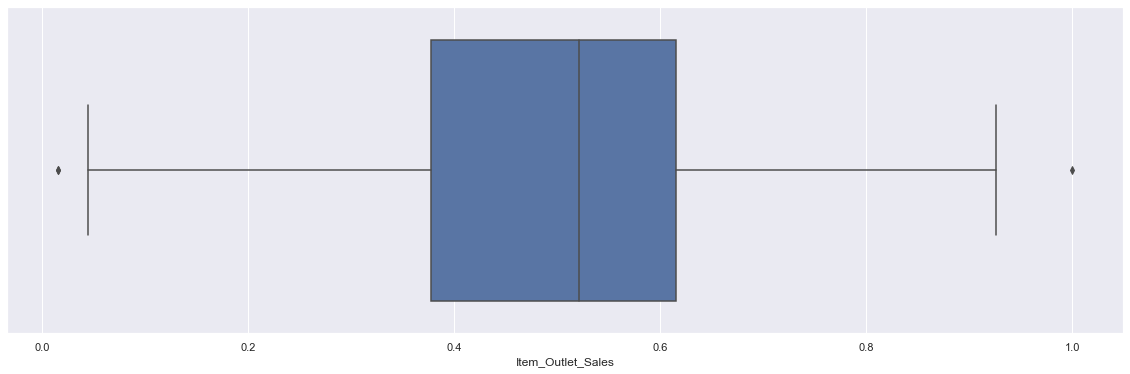

In [50]:
# float plot
for i in dfx.columns:
    if dfx[i].dtype == np.float64:        
        print(i)
        print('normal')
        sns.boxplot(dfx[dfx['outlier']==0][i])
        plt.show()
        print('outlier')
        sns.boxplot(dfx[dfx['outlier']==1][i])
        plt.show()